In [1]:
import pickle
import pandas as pd
import os
from utils.plot_decision_trees import plot_tree


from utils.pre_process_data import get_data
from math import ceil
from utils.units import Volume, Dollar
from deap import gp, creator, base, tools
from deap.gp import Terminal
from operator import or_, and_, gt
from fitness_functions import *
from utils.plot_decision_trees import plot_tree
from utils.save_info import save_results
from genetic_functions.cx_functions import cxSubTree
from genetic_functions.mut_functions import mutation_half, mutBranch
from genetic_functions.genetic_program import GPAlgo
import matplotlib.pyplot as plt
import pendulum


In [2]:
df = get_data()
df_train= df.iloc[ : ceil(len(df)*0.7)]
df_test= df.iloc[ceil(len(df)*0.7) : ]

arg_names = list(df_train.columns)
vol_args = [arg for arg in arg_names if "volume" in arg.lower()]
dol_args = [arg for arg in arg_names if "volume" not in arg.lower()]


pset = gp.PrimitiveSetTyped("main",[Volume]*len(vol_args) + [Dollar]*len(dol_args),bool)
        #Rename the arguments:
arg_vol_mapping = {f"ARG{ind}": val for ind,val in enumerate(vol_args)}
pset.renameArguments(**arg_vol_mapping)
arg_dol_mapping = {f"ARG{len(vol_args)+ind}": val for ind,val in enumerate(dol_args)}
pset.renameArguments(**arg_dol_mapping)
#Check that all arguments were renamed:
unnamed_args=[i for i in pset.arguments if "ARG" in i]
if  unnamed_args:
    print(f"Some arguments were not renamed: {unnamed_args}")
pset.addPrimitive(gt, [Dollar,Dollar],bool)
pset.addPrimitive(lambda x:x ,[Dollar],Dollar, name="dollar placeholder")

pset.addPrimitive(gt, [Volume,Volume],bool)
pset.addPrimitive(lambda x:x ,[Volume],Volume, name="volume placeholder")


#Boolean operators:
pset.addPrimitive(and_, [bool,bool],bool)
pset.addPrimitive(or_,[bool,bool],bool)

for v_arg in vol_args:
        pset.addTerminal(v_arg,Volume)
for d_arg in dol_args:
        pset.addTerminal(d_arg,Dollar)

# --- Remove all the ARG terminals ---
pset.terminals[Volume] = [i for i in pset.terminals[Volume] if "ARG" not in i.name]
pset.terminals[Dollar] = [i for i in pset.terminals[Dollar] if "ARG" not in i.name]

def generate(pset):
    run=True
    while run:
        try:
            expr = toolbox.individual()            
            #Remove all the Lambda functions:
            expr=  list(filter(lambda x: x.name!="dollar placeholder", expr))
            expr=  list(filter(lambda x: x.name!="volume placeholder", expr))
            if len(expr)>3:
                run=False
        except IndexError:
            continue
    # return gp.PrimitiveTree(expr)
    return creator.Individual(expr)

# --- GP OPERATORS ----

creator.create("fitness", base.Fitness, weights=(1,))
creator.create("Individual", gp.PrimitiveTree, fitness= creator.fitness)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=5)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("custom_individual",generate, pset)
toolbox.register("population", tools.initRepeat, list, toolbox.custom_individual)
toolbox.register("evaluate", fitness_function, df=df_train, pset=pset)

toolbox.register("mate",       cxSubTree)
toolbox.register("select",     tools.selRoulette) 
toolbox.register("mutate",     mutation_half, pset=pset)

hof   = tools.HallOfFame(maxsize=50)

#STATS:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean, axis=0) 
stats.register("std", np.std, axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)

/home/khann/masters/utils/pre_process_data.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"lag_{column.lower()}_{lag}"]= df[column].shift(lag)
/home/khann/masters/utils/pre_process_data.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"lag_{column.lower()}_{lag}"]= df[column].shift(lag)
/home/khann/masters/utils/pre_process_data.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at

In [17]:
run_list = os.listdir("results")

In [18]:
best_sol_pop = []
for dir in run_list:
    if os.path.isdir(rf"/home/khann/masters/results/{dir}"):
        with open(rf"/home/khann/masters/results/{dir}/hof.pkl", 'rb') as file:
        # Serialize the object and write it to the file
            hof = pickle.load(file)
            best_sol_pop.append(hof[0])
            best_sol_pop.append(hof[1])

[[<deap.gp.Primitive at 0x7f2649a5fce0>,

In [47]:
best_sol_pop = []
for dir in run_list[:2]:
    if os.path.isdir(rf"/home/khann/masters/results/{dir}"):
        d = pd.read_csv(rf"/home/khann/masters/results/{dir}/run_info.csv")

In [79]:
t = d.copy()
t

,Unnamed: 0,population_number,generations,run_time,best_tree,trading_cost,buy_hold_train,strategy_value_train,buy_hold_test,strategy_value_test,time
0,0,100,50,24148,"or_(gt('ma_close_9', 'ma_close_41'), gt('ma_vo...",1.0%,116918.977037,93458.631839,1163.710097,690.440269,2024-08-03 08:58:26.549738+00:00


In [21]:
hof.items[0]

In [22]:
# res = pd.read_csv(r"/home/khann/masters/results/run_2024-08-03_08-38/run_info.csv")
# res.columns

In [23]:
best_sol_pop.sort(key = lambda x : x.fitness.values)

In [24]:
plot_tree(best_sol_pop[0] , name="tree_gen1_best_sol")

In [25]:
best_sol_pop

[[<deap.gp.Primitive at 0x7f264c240fe0>,

In [26]:
for i in best_sol_pop:
    per = [k for k in str(i).split("'") if "percent" in k]
    if per:
        print(per[0].split("_")[-1])

37
37
37
37


In [51]:

with open(rf"/home/khann/masters/results/run2_2024-08-09_09-20/logbook.pkl", 'rb') as file:
# Serialize the object and write it to the file
    logbook = pickle.load(file)

with open(rf"/home/khann/masters/results/run2_2024-08-09_09-20/hof.pkl", 'rb') as file:
# Serialize the object and write it to the file
    hof2 = pickle.load(file)

In [28]:
logbook[-1]

{'gen': 50,
 'nevals': 179,
 'avg': array([6556.37844814]),
 'std': array([19013.60832643]),
 'min': array([5.12736613e-10]),
 'max': array([114690.72458003])}

In [29]:
max_lst = []
for i in logbook:
    max_lst.append(i['max'])
x=range(0,len(max_lst))

In [30]:
import matplotlib.pyplot as plt

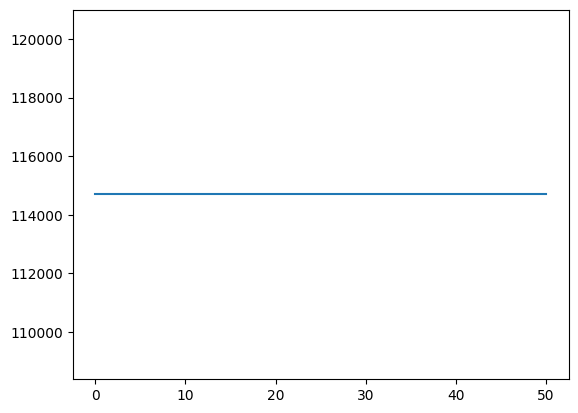

In [31]:
plt.plot(x,max_lst)

In [40]:
max([i.fitness.values for i in best_sol_pop])

(np.float64(114690.72458002997),)

In [45]:
best_solution = best_sol_pop[0]
tc = 0.01
print("TRAIN")
print("Buy and hold:",(1000/df_test.iloc[0]['Open'])*df_test.iloc[-1]['Open']*(1-tc)**2)
print("mtv         :",maximum_theoretical_value(df_test))
print("strat value :",trading_strat(individual = best_solution, df=df_test,pset=pset)[0],'\n')

TRAIN
Buy and hold: 1163.7100970760914
mtv         : 177218.81839494675
strat value : 290.61361890401014 



In [46]:
lst = []
for i in best_sol_pop:
    lst.append(trading_strat(individual = i, df=df_test,pset=pset)[0])

In [50]:
max(lst)

1401.2000275998862

In [70]:
lst_hof_test = []
for i in hof2:
    lst_hof_test.append(trading_strat(individual = i, df=df_test,pset=pset)[:2])

lst_hof_train = []
for i in hof2:
    lst_hof_train.append(trading_strat(individual = i, df=df_train ,pset=pset)[:2])

In [56]:
[i for i in lst if i>1163]

[1235.2377384287424, 1227.4131529293672, 1247.2318559636708]

In [57]:
print("Buy and hold:",(1000/df_train.iloc[0]['Open'])*df_train.iloc[-1]['Open']*(1-tc)**2)


Buy and hold: 116918.97703677377


Text(0.5, 1.0, 'Fitness values of the strategies.')

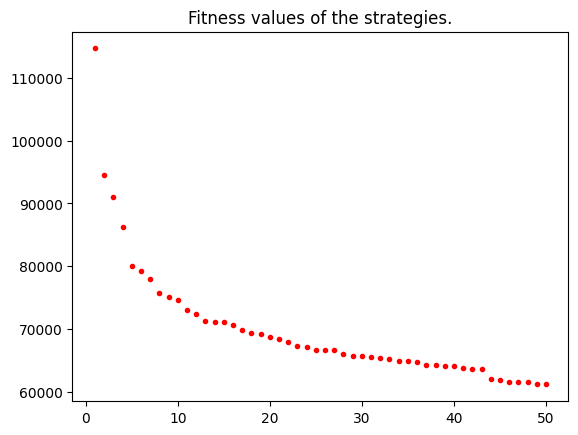

In [72]:
plt.plot(range(1,len(hof2)+1),[i.fitness.values for i in hof2],'r.')
plt.title("Fitness values of the strategies.")


Text(0.5, 1.0, 'test data')

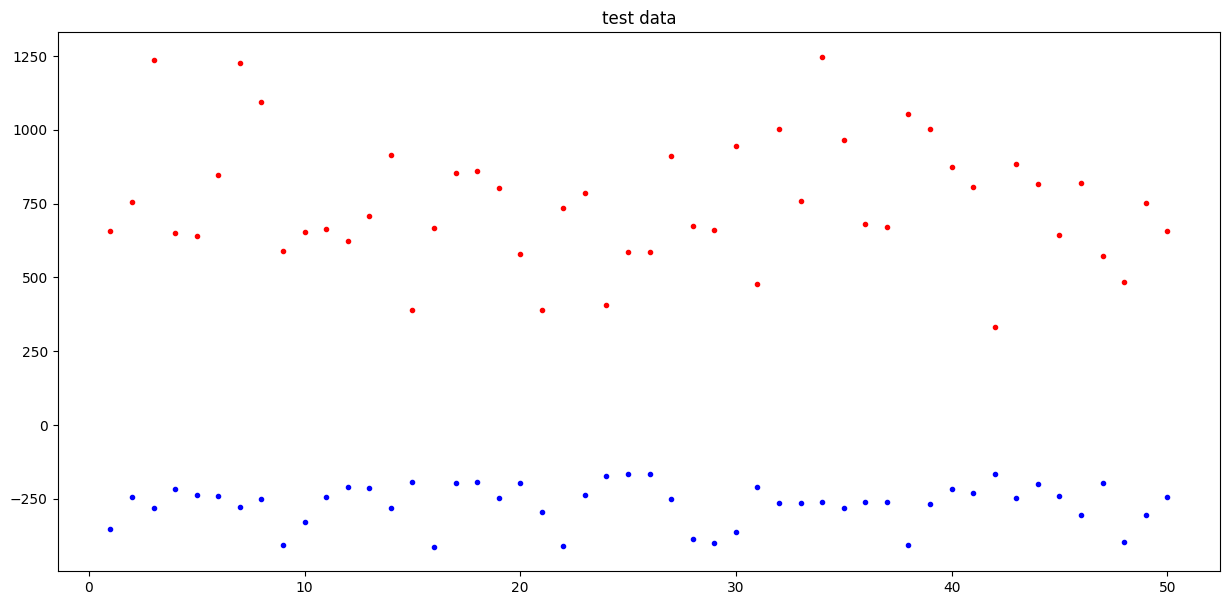

In [75]:
plt.figure(figsize=(15,7))
plt.plot(range(1,len(hof2)+1),[i[0] for i in lst_hof_test],'r.')
plt.plot(range(1,len(hof2)+1),[i[1] for i in lst_hof_test],'b.')


plt.title("test data")

Text(0.5, 1.0, 'train data')

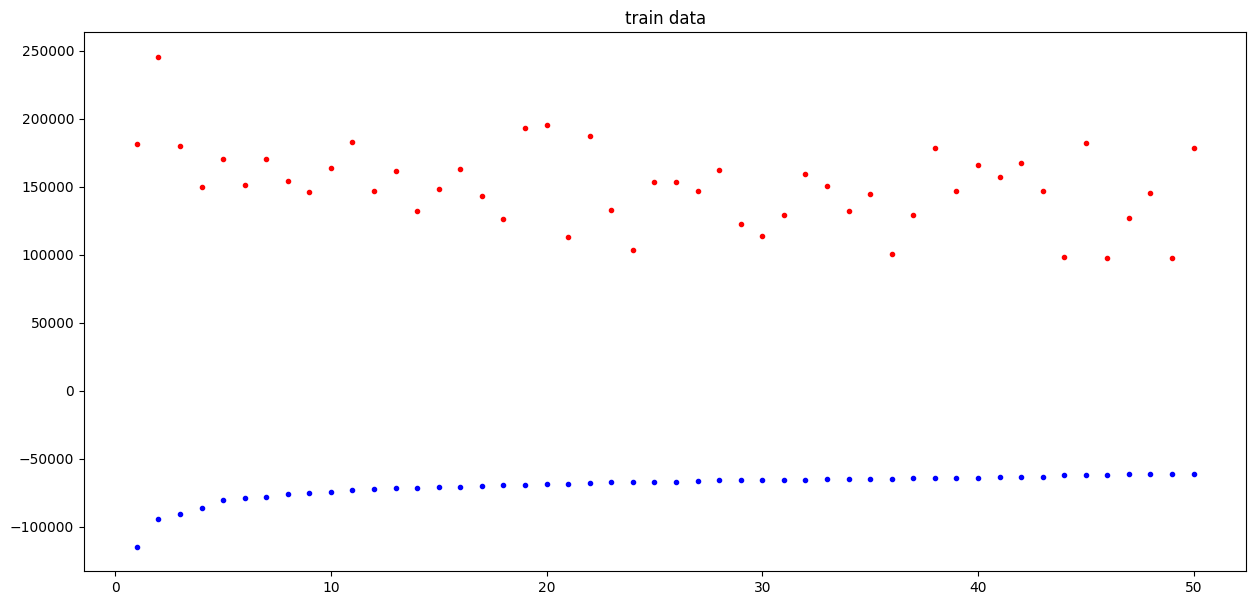

In [76]:
plt.figure(figsize=(15,7))
plt.plot(range(1,len(hof2)+1),[i[0] for i in lst_hof_train],'r.')
plt.plot(range(1,len(hof2)+1),[i[1] for i in lst_hof_train],'b.')


plt.title("train data")